In [1]:
import model
import numpy as np
import random
import tank
import truck

import gym_pdsystem

import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import animation, rc
from IPython.display import HTML

import pandas as pd
import time

from gym_pdsystem.envs.pdsystem_env import PDSystemEnv
import gym_pdsystem.utils.utilsq as ut
import gym_pdsystem.utils.constants as ct
import gym_pdsystem.utils.functions as fnc

import os

simulations_directory = './simulations'
if not os.path.exists(simulations_directory):
    os.makedirs(simulations_directory)


In [2]:
COEFF = ct.COEFF

C_TRANSPORT = ct.C_TRANSPORT
C_LEVELS = ct.C_LEVELS

p0_GLOBAL = ct.p0_GLOBAL

P1_GLOBAL = ct.P1_GLOBAL
P2_GLOBAL = ct.P2_GLOBAL

M_GLOBAL = ct.M_GLOBAL

NOT_DELIVERYING_PENALTY = P2_GLOBAL #to be equivalent/same importance as having 0 stock or surpassing max capacity levels


## System initializer

In [3]:
def initialize_test_system(seed = None):
    if seed != None:
        np.random.seed(seed)

    # Tanks' information
    global n
    n = 5 
    tank_ids = list(range(1,n+1))
    tank_max_loads =  np.array([100., 200, 100., 800., 200.])
    C_max = np.array([ [load] for load in tank_max_loads ])

    tank_current_loads = np.full(n,0)
    tank_consumption_rates =  np.array([5.] * n)
    noisy_consumption_rate = False
    
    global n_discrete_load_levels
    n_discrete_load_levels = np.array([4,4,4,4,4])
    
    load_level_percentages = np.array([ #b , c, e
                                            [0.02, 0.31, 0.9],
                                            [0.01, 0.03, 0.9],
                                            [0.05, 0.16, 0.9],
                                            [0.07, 0.14, 0.85],
                                            [0.08, 0.26, 0.9]
                                               ])
    for i in range(n):
        tank_consumption_rates[i] = tank_max_loads[i] * (load_level_percentages[i][0] + load_level_percentages[i][1])/2.0
        
    tank_levels = np.multiply(C_max,load_level_percentages)
    
    for i, tank_level in enumerate(tank_levels):
                a = tank_level[0]
                b = tank_level[-1]
                #current_load = 0.75 * (a+b)/2.0# np.random.randint(a+1,b, size =(1,)) GIVES A STRANGE ERROR
                current_load = np.random.random() * (b - a-1) + a+1 #np.random.randint(a+1,b)
                tank_current_loads[i] = current_load * 1.0
                
#     for i, (lvl, max_load) in enumerate(zip(n_discrete_load_levels, tank_max_loads)):
#         a = np.linspace(0,max_load, lvl+1)[1]
#         current_load = np.random.randint(a+1,max_load)
#         tank_current_loads[i] = current_load     

    # Trucks' information
    global k
    k = 2
    truck_ids = list(range(k))
    truck_max_loads = np.array([70.,130.])
    truck_current_loads = truck_max_loads.copy()
    truck_current_positions =  np.array([5] * k)
    #truck_fractions_deliverable =  np.array([1.] * k) # we for now we only allow to deliver all the content of the truck
    truck_fractions_deliverable =  np.array([ np.array([1.]), 
                                              np.array([1.])
                                            ]) # we for now we only allow to deliver all the content of the truck
    global n_discrete_load_levels_trucks
    n_discrete_load_levels_trucks = np.array([1,1])

    # System's information
   
    graph = ut.simple_graph(n+1)
    tanks = [tank.Tank( tank_id, current_load, max_load, consumption_rate, n_lvls, d_lvls, noisy_consumption_rate) 
             for  tank_id, current_load, max_load, consumption_rate, n_lvls, d_lvls in 
             zip( tank_ids, tank_current_loads, tank_max_loads, tank_consumption_rates, n_discrete_load_levels,
                  load_level_percentages)]
    trucks = [truck.Truck( truck_id, current_load, max_load, current_position, load_fractions_deliverable, n_lvls) 
             for  truck_id, current_load, max_load, current_position, load_fractions_deliverable, n_lvls in 
             zip(truck_ids, truck_current_loads, truck_max_loads, truck_current_positions, 
                 truck_fractions_deliverable, n_discrete_load_levels_trucks)]

    w =  np.array([32., 159., 162., 156.,156., 0.])

    weights_matrix = ut.simple_weights(n+1, w)
    
    return(tanks, trucks, graph, weights_matrix)

tanks, trucks, graph, weights_matrix = initialize_test_system()
toy_system = model.System(tanks = tanks, trucks = trucks, adjacency_matrix = graph, weights_matrix = weights_matrix)

# Action-State space dimension
a_s_dim = toy_system.states_dim * toy_system.actions_dim
a_s_dim

368640

In [4]:
tanks, trucks, graph, weights_matrix = initialize_test_system(seed = 42)
system = model.System(tanks = tanks, trucks = trucks, adjacency_matrix = graph, weights_matrix = weights_matrix)
print(system.tank_loads())
print(system.graph)
print(system.weights)

[35, 171, 67, 429, 42]
[[0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [1 1 1 1 1 1]]
[[ inf  inf  inf  inf  inf  inf]
 [ inf  inf  inf  inf  inf  inf]
 [ inf  inf  inf  inf  inf  inf]
 [ inf  inf  inf  inf  inf  inf]
 [ inf  inf  inf  inf  inf  inf]
 [ 32. 159. 162. 156. 156.   0.]]


### Reinitialize system function

In [5]:
def reinitialize_system(system, seed = None):
    if seed != None:
        np.random.seed(seed)
        
    for tank, tank_levels in zip(system.tanks, system.tanks_level):
        a = tank_levels[0]
        b = tank_levels[-1]
        current_load = np.random.random() * (b - a-1) + a+1 #np.random.randint(a+1,b)*1.0
        tank.load = current_load
    system.reset_trucks_positions(); 
    return(system)    

## Q-learning algorithm (off-policy)


### Training

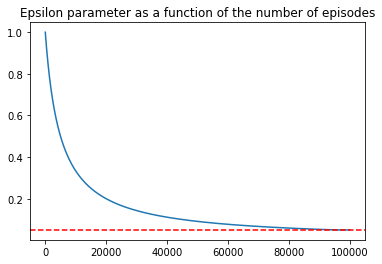

In [6]:
# Retrain parameters:
retrain = False

episode_retrain = 2*10**3 # episode number from which start the retrain. Ensure that a file with this number in 
                          # the Q filename is available.
retrain_episodes = 1*10**3


# Train parameters:
train_epsilon = True

learning_rate0 = 1 
learning_rate_decay = 0 

episode_length = 30
discount_rate = 0.9

episodes = 1*10**5
episodes_epsilon_min = 0.05*episodes

# Output's frequencies
train_freq = 10**2 # 10**4
train_vis_freq =  np.inf #10**3
train_rew_freq =  10**2
train_Q_freq =  10**3

epsilon0 = 1.0
epsilon_decay =( 1./(episodes_epsilon_min) ) 
epsilon_min = 0.05

verbose = False
verbose_info = False

seed = 42

simulation_id = 16

# Visualization of the epsilon parameter value that will be present duing the simulation
% matplotlib inline

def epsilon_fnc(x, epsilon0 = epsilon0, decay = epsilon_decay, epsilon_min = epsilon_min):
    e_mins = epsilon_min * np.ones(len(x))
    eps = epsilon0 / (1.0 + (x-1)*epsilon_decay)
    return np.maximum(e_mins, eps )

t = np.arange(1, episodes, 1)
epsilon = epsilon_fnc(t)

plt.plot(t, epsilon)
plt.axhline(y= epsilon_min, xmin=0, xmax=episodes, hold=None, color = "Red", linestyle = '--')

plt.title("Epsilon parameter as a function of the number of episodes");

In [7]:
train_visualization_steps = []
train_rewards_list = []

tanks, trucks, graph, weights_matrix = initialize_test_system()
toy_system = model.System(tanks = tanks, trucks = trucks, adjacency_matrix = graph, weights_matrix = weights_matrix)

Q = {}

# Create directories for the simulations' outputs

simulation_directory = './simulations/simulation{}'.format(simulation_id)
if not os.path.exists(simulation_directory):
    os.makedirs(simulation_directory)
    os.makedirs(simulation_directory + '/Q-dictionaries')
    os.makedirs(simulation_directory + '/discrewards')
    os.makedirs(simulation_directory + '/vis')
    
else:
    raise Exception("The simulation id you tried to use has been already used before. Try to change it to a new one.")

    
ut.save_obj(toy_system, simulation_directory+"/system-sim"+f"{simulation_id}") 

rewards_file = simulation_directory+'/discrewards'+ '/rewards-sim{}.csv'.format(simulation_id)

In [8]:
# Output headers to file
with open(rewards_file,'w') as f:
     np.savetxt(f, [["episode", "discreward"]], fmt="%s", delimiter=',')  

def episodic_train_Q_epsilon( 
            epsilon0 = epsilon0,
            epsilon_min = epsilon_min,
            n_episodes = episodes, 
            episode_length = episode_length,
            learning_rate0 = learning_rate0,
            learning_rate_decay = learning_rate_decay,
            discount_rate = discount_rate,
            system = toy_system,
            Q = Q, verbose = verbose, verbose_info = verbose_info,
            visualization_steps = train_visualization_steps, rewards_list = train_rewards_list,
            seed = seed, 
            freq = train_freq,
            vis_freq = train_vis_freq,
            rew_freq = train_rew_freq,
            Q_freq = train_Q_freq,
            simulation_id = simulation_id,
            round_time = 2
    
           ):
    
    time_start = time.time()
    
    for episode in range(1,n_episodes+1):
        print("\rEpisode: {}".format(episode), end="")

        reinitialize_system(system, seed = episode)
        
        ### epsilon-greedy exploration
        epsilon = max( epsilon_min, epsilon0 / (1+(episode-1)*epsilon_decay) ) 
        
        ### decrement of learning rate
        learning_rate = learning_rate0 / (1+(episode-1)*learning_rate_decay)        

        discounted_reward = 0
        
        for t in range(episode_length):

            system.update_state()
            s_current = system.state_to_string()                
            p = np.random.uniform()

            if p > epsilon:
                #DETERMINISTIC ACTION OPTIMAL
                s0 = system.state_to_string()
                best_action = optimal_policy(s0, Q)
                if best_action == None:
                    reward = system.random_action(seed = (seed + (t+1)*episode), verbose = verbose)
                else:
                    reward = system.deterministic_action(best_action)
                #print(best_action)
            else:
                reward = system.random_action(seed = (seed + (t+1)*episode), verbose = verbose)

            a_current = system.action_to_string()
            sa_current = ''.join([s_current, a_current])

            system.update_state()
            sa_new = system.state_action_to_string()

            if ut.is_key(Q, sa_current) == False:
                Q[sa_current] = 0

            Q_max = max([Q[key] for key in Q.keys() if key.startswith(sa_new[0:system.state_length])]+[0.0]) 

            if Q[sa_current] != -np.inf:
                Q[sa_current] = ( (1-learning_rate) * Q[sa_current] 
                                 + learning_rate* (reward + discount_rate * Q_max)
                                )
                
            discounted_reward = discounted_reward + (discount_rate**t) * reward
            system.reset_trucks_positions();     
            system.reset_trucks_loads();
            
        #rewards_list.append(discounted_reward);
        if episode % freq == 0:
                time_end = time.time()
                print(". Elapsed time ", round( (time_end-time_start)/60., round_time), " minuts.",
                      "epsilon", round(epsilon,4), 
                     "Discounted reward: ", discounted_reward)
                
                if verbose_info:
                    print("s, a", system.s, system.a)
                    print("ds, da", system.ds, system.da)
        if episode % Q_freq == 0:           
                ut.save_obj(Q, simulation_directory +"/Q-dictionaries/Q-dict-sim" + f"{simulation_id}" + "-" + f"{episode}")   

        if episode % vis_freq == 0:
                #Save visualization and rewards
                visualization_steps.append(toy_system.visualize());
                ut.save_obj(visualization_steps, simulation_directory +"/vis/vis-train-sim" + f"{simulation_id}" + "-" + f"{episode}")   
                                
        if episode % rew_freq == 0:
                #rewards_list.append(discounted_reward);
                #ut.save_obj(rewards_list, simulation_directory +"/discrewards/discrew-train-sim" + f"{simulation_id}" + "-" + f"{episode}")
                # Output data to files
                with open(rewards_file,'ab') as f:
                    np.savetxt(f, [np.array([episode, discounted_reward])], fmt=("%d",'%.10f'), delimiter=',')    
        
    end_time = round(time.time()-time_start,round_time)        
    print(f"Training finished. Total episodes: {n_episodes}. Elapsed time: {round(end_time/60., round_time)} minutes.")        

In [9]:
# Given a state, returns the action that has the highest Q-value.

def optimal_policy(state, Q, system = toy_system):
    """
    state must be in the string-integers code
    """
    state_keys = [key for key in list(Q) if key.startswith(state)]
    if len(state_keys) == 0:
        return(None)
    
    state_q = [Q[state_key] for state_key in state_keys]
    
    #print("state_q ", state_q[1:min(10,len(state_q))])
    
    max_q = max(state_q)
    #print("max_q", max_q)
    optimal_key_index = np.where(np.isin(state_q, max_q ))[0][0]
    #print("optimal_key_index", optimal_key_index)
    optimal_key = state_keys[optimal_key_index]
    #print("optimal_key", optimal_key)
    optimal_action = optimal_key[system.state_length:]
    
    return(optimal_action)
    

In [10]:
if train_epsilon == True and retrain == False:
    episodic_train_Q_epsilon()
elif train_epsilon == False and retrain == True:
    Q_retrain = ut.load_obj(simulation_directory + "/Q-dictionaries/Q-dict-sim" + f"{simulation_id}" + "-" + f"{episode_retrain}")
    episodic_train_Q_epsilon(n_episodes = retrain_episodes, Q = Q_retrain)
else:
    raise Exception("Only one of the parameters train_epsilon or retrain parameters can be set to True.")
    
    

Episode: 100. Elapsed time  0.05  minuts. epsilon 0.9806 Discounted reward:  -19.136877774372866
Episode: 200. Elapsed time  0.11  minuts. epsilon 0.9617 Discounted reward:  -16.292788215492333
Episode: 300. Elapsed time  0.19  minuts. epsilon 0.9436 Discounted reward:  -18.015573692240483
Episode: 400. Elapsed time  0.29  minuts. epsilon 0.9261 Discounted reward:  -14.601487730972977
Episode: 500. Elapsed time  0.38  minuts. epsilon 0.9093 Discounted reward:  -18.5189799613021
Episode: 600. Elapsed time  0.48  minuts. epsilon 0.893 Discounted reward:  -16.579655484336286
Episode: 700. Elapsed time  0.6  minuts. epsilon 0.8773 Discounted reward:  -16.74166478360678
Episode: 800. Elapsed time  0.71  minuts. epsilon 0.8622 Discounted reward:  -17.728028749511825
Episode: 900. Elapsed time  0.83  minuts. epsilon 0.8476 Discounted reward:  -15.131617049800418
Episode: 1000. Elapsed time  0.96  minuts. epsilon 0.8335 Discounted reward:  -14.320464390838108
Episode: 1100. Elapsed time  1.11 

Episode: 8500. Elapsed time  22.13  minuts. epsilon 0.3704 Discounted reward:  -6.568057898334177
Episode: 8600. Elapsed time  22.52  minuts. epsilon 0.3677 Discounted reward:  -3.8251391651280815
Episode: 8700. Elapsed time  22.9  minuts. epsilon 0.365 Discounted reward:  -2.3109997851438973
Episode: 8800. Elapsed time  23.27  minuts. epsilon 0.3623 Discounted reward:  -6.18679873219328
Episode: 8900. Elapsed time  23.65  minuts. epsilon 0.3597 Discounted reward:  -4.470858977013009
Episode: 9000. Elapsed time  24.02  minuts. epsilon 0.3572 Discounted reward:  -8.741946057744098
Episode: 9100. Elapsed time  24.4  minuts. epsilon 0.3546 Discounted reward:  -8.71706842756281
Episode: 9200. Elapsed time  24.77  minuts. epsilon 0.3521 Discounted reward:  -5.080222758525649
Episode: 9300. Elapsed time  25.19  minuts. epsilon 0.3497 Discounted reward:  -10.626712001327716
Episode: 9400. Elapsed time  25.58  minuts. epsilon 0.3472 Discounted reward:  -4.980260052236103
Episode: 9500. Elapsed

Episode: 16800. Elapsed time  57.24  minuts. epsilon 0.2294 Discounted reward:  -2.4692055384142297
Episode: 16900. Elapsed time  57.69  minuts. epsilon 0.2283 Discounted reward:  -2.2480465114070713
Episode: 17000. Elapsed time  58.14  minuts. epsilon 0.2273 Discounted reward:  -2.074906170886907
Episode: 17100. Elapsed time  58.6  minuts. epsilon 0.2263 Discounted reward:  -5.310364762723943
Episode: 17200. Elapsed time  59.06  minuts. epsilon 0.2252 Discounted reward:  -1.7628690933182791
Episode: 17300. Elapsed time  59.53  minuts. epsilon 0.2242 Discounted reward:  -3.3061099795994724
Episode: 17400. Elapsed time  59.98  minuts. epsilon 0.2232 Discounted reward:  -5.056993211713153
Episode: 17500. Elapsed time  60.43  minuts. epsilon 0.2222 Discounted reward:  -2.506017912806618
Episode: 17600. Elapsed time  60.88  minuts. epsilon 0.2212 Discounted reward:  -1.0006472366486543
Episode: 17700. Elapsed time  61.33  minuts. epsilon 0.2203 Discounted reward:  -6.499985311973142
Episod

Episode: 25100. Elapsed time  96.66  minuts. epsilon 0.1661 Discounted reward:  -1.4614423958314802
Episode: 25200. Elapsed time  97.15  minuts. epsilon 0.1656 Discounted reward:  -5.466259549167188
Episode: 25300. Elapsed time  97.65  minuts. epsilon 0.165 Discounted reward:  -0.896512824026835
Episode: 25400. Elapsed time  98.14  minuts. epsilon 0.1645 Discounted reward:  -0.2564708639334624
Episode: 25500. Elapsed time  98.66  minuts. epsilon 0.1639 Discounted reward:  -1.8402584760420417
Episode: 25600. Elapsed time  99.21  minuts. epsilon 0.1634 Discounted reward:  -2.244478375805697
Episode: 25700. Elapsed time  99.73  minuts. epsilon 0.1629 Discounted reward:  -2.8373705118425496
Episode: 25800. Elapsed time  100.23  minuts. epsilon 0.1623 Discounted reward:  -1.6747829075997855
Episode: 25900. Elapsed time  100.72  minuts. epsilon 0.1618 Discounted reward:  -2.5674171661475587
Episode: 26000. Elapsed time  101.2  minuts. epsilon 0.1613 Discounted reward:  -2.878948860110132
Epi

Episode: 33300. Elapsed time  138.15  minuts. epsilon 0.1306 Discounted reward:  -1.5184689929574882
Episode: 33400. Elapsed time  138.66  minuts. epsilon 0.1302 Discounted reward:  -0.9893781892868655
Episode: 33500. Elapsed time  139.17  minuts. epsilon 0.1299 Discounted reward:  -4.089470994326932
Episode: 33600. Elapsed time  139.67  minuts. epsilon 0.1295 Discounted reward:  -1.554522777328969
Episode: 33700. Elapsed time  140.16  minuts. epsilon 0.1292 Discounted reward:  -1.6940477158837757
Episode: 33800. Elapsed time  140.72  minuts. epsilon 0.1289 Discounted reward:  -2.609252296017602
Episode: 33900. Elapsed time  141.28  minuts. epsilon 0.1285 Discounted reward:  0.0013435508585825596
Episode: 34000. Elapsed time  141.8  minuts. epsilon 0.1282 Discounted reward:  -1.3563096916426896
Episode: 34100. Elapsed time  142.33  minuts. epsilon 0.1279 Discounted reward:  -1.1714680640610342
Episode: 34200. Elapsed time  142.9  minuts. epsilon 0.1276 Discounted reward:  -0.7727017840

Episode: 41500. Elapsed time  182.23  minuts. epsilon 0.1075 Discounted reward:  0.002651634615261228
Episode: 41600. Elapsed time  182.79  minuts. epsilon 0.1073 Discounted reward:  -2.0467211862967285
Episode: 41700. Elapsed time  183.36  minuts. epsilon 0.1071 Discounted reward:  -5.274593028186479
Episode: 41800. Elapsed time  183.92  minuts. epsilon 0.1068 Discounted reward:  -1.592306761383921
Episode: 41900. Elapsed time  184.46  minuts. epsilon 0.1066 Discounted reward:  -1.5227587699413294
Episode: 42000. Elapsed time  185.01  minuts. epsilon 0.1064 Discounted reward:  -1.2778816708361351
Episode: 42100. Elapsed time  185.57  minuts. epsilon 0.1062 Discounted reward:  -0.706152361478453
Episode: 42200. Elapsed time  186.13  minuts. epsilon 0.1059 Discounted reward:  -2.777964338751144
Episode: 42300. Elapsed time  186.68  minuts. epsilon 0.1057 Discounted reward:  -0.2118603573637586
Episode: 42400. Elapsed time  187.23  minuts. epsilon 0.1055 Discounted reward:  -1.7814862262

Episode: 49700. Elapsed time  224.87  minuts. epsilon 0.0914 Discounted reward:  0.0018249437498419868
Episode: 49800. Elapsed time  225.38  minuts. epsilon 0.0912 Discounted reward:  -0.28409605375234515
Episode: 49900. Elapsed time  225.88  minuts. epsilon 0.0911 Discounted reward:  -0.6526619560671776
Episode: 50000. Elapsed time  226.39  minuts. epsilon 0.0909 Discounted reward:  0.0022055027571244285
Episode: 50100. Elapsed time  226.9  minuts. epsilon 0.0907 Discounted reward:  -2.2591115258324903
Episode: 50200. Elapsed time  227.4  minuts. epsilon 0.0906 Discounted reward:  -0.13364068991496092
Episode: 50300. Elapsed time  227.92  minuts. epsilon 0.0904 Discounted reward:  -3.3092994552387367
Episode: 50400. Elapsed time  228.43  minuts. epsilon 0.0903 Discounted reward:  -1.218497203293359
Episode: 50500. Elapsed time  228.95  minuts. epsilon 0.0901 Discounted reward:  -1.993652430272032
Episode: 50600. Elapsed time  229.49  minuts. epsilon 0.0899 Discounted reward:  -2.83427

Episode: 57900. Elapsed time  265.96  minuts. epsilon 0.0795 Discounted reward:  -0.4428501390928077
Episode: 58000. Elapsed time  266.43  minuts. epsilon 0.0794 Discounted reward:  -1.7386254470527578
Episode: 58100. Elapsed time  266.9  minuts. epsilon 0.0792 Discounted reward:  -0.899322161465318
Episode: 58200. Elapsed time  267.38  minuts. epsilon 0.0791 Discounted reward:  -0.863159279869388
Episode: 58300. Elapsed time  267.85  minuts. epsilon 0.079 Discounted reward:  0.0030137650787217672
Episode: 58400. Elapsed time  268.34  minuts. epsilon 0.0789 Discounted reward:  -0.48042935812024196
Episode: 58500. Elapsed time  268.8  minuts. epsilon 0.0787 Discounted reward:  -0.15789397001890046
Episode: 58600. Elapsed time  269.28  minuts. epsilon 0.0786 Discounted reward:  -2.0072706206482267
Episode: 58700. Elapsed time  269.76  minuts. epsilon 0.0785 Discounted reward:  -0.15698568362309503
Episode: 58800. Elapsed time  270.23  minuts. epsilon 0.0784 Discounted reward:  -0.8396749

Episode: 66000. Elapsed time  304.91  minuts. epsilon 0.0704 Discounted reward:  -0.7425434192165483
Episode: 66100. Elapsed time  305.4  minuts. epsilon 0.0703 Discounted reward:  -1.6693605684186217
Episode: 66200. Elapsed time  305.89  minuts. epsilon 0.0702 Discounted reward:  -1.2548739849038557
Episode: 66300. Elapsed time  306.37  minuts. epsilon 0.0701 Discounted reward:  -0.11956177891955516
Episode: 66400. Elapsed time  306.85  minuts. epsilon 0.07 Discounted reward:  -0.48103657894622764
Episode: 66500. Elapsed time  307.34  minuts. epsilon 0.0699 Discounted reward:  0.003338028446150786
Episode: 66600. Elapsed time  307.83  minuts. epsilon 0.0698 Discounted reward:  0.002709645888019046
Episode: 66700. Elapsed time  308.3  minuts. epsilon 0.0697 Discounted reward:  -0.22607824380225444
Episode: 66800. Elapsed time  308.78  minuts. epsilon 0.0696 Discounted reward:  -1.1414848012138281
Episode: 66900. Elapsed time  309.27  minuts. epsilon 0.0695 Discounted reward:  0.0024261

Episode: 74100. Elapsed time  344.06  minuts. epsilon 0.0632 Discounted reward:  -0.9973883664218238
Episode: 74200. Elapsed time  344.54  minuts. epsilon 0.0631 Discounted reward:  -1.0082108564026442
Episode: 74300. Elapsed time  345.03  minuts. epsilon 0.0631 Discounted reward:  -1.9657785539723647
Episode: 74400. Elapsed time  345.52  minuts. epsilon 0.063 Discounted reward:  -0.60912558717285
Episode: 74500. Elapsed time  345.99  minuts. epsilon 0.0629 Discounted reward:  -0.20381158749476225
Episode: 74600. Elapsed time  346.47  minuts. epsilon 0.0628 Discounted reward:  -0.11381743612498917
Episode: 74700. Elapsed time  346.96  minuts. epsilon 0.0627 Discounted reward:  -0.7226237595118297
Episode: 74800. Elapsed time  347.45  minuts. epsilon 0.0627 Discounted reward:  -0.3539737178252077
Episode: 74900. Elapsed time  347.93  minuts. epsilon 0.0626 Discounted reward:  -0.26348820273090817
Episode: 75000. Elapsed time  348.42  minuts. epsilon 0.0625 Discounted reward:  -0.3133315

Episode: 82200. Elapsed time  383.37  minuts. epsilon 0.0573 Discounted reward:  -0.9671740363325305
Episode: 82300. Elapsed time  383.85  minuts. epsilon 0.0573 Discounted reward:  -0.050683092477900926
Episode: 82400. Elapsed time  384.34  minuts. epsilon 0.0572 Discounted reward:  0.0028200891297816624
Episode: 82500. Elapsed time  384.82  minuts. epsilon 0.0571 Discounted reward:  -0.3167131972485612
Episode: 82600. Elapsed time  385.32  minuts. epsilon 0.0571 Discounted reward:  -4.7750129166391
Episode: 82700. Elapsed time  385.82  minuts. epsilon 0.057 Discounted reward:  -0.6247581112137206
Episode: 82800. Elapsed time  386.3  minuts. epsilon 0.0569 Discounted reward:  -1.4410508958506378
Episode: 82900. Elapsed time  386.78  minuts. epsilon 0.0569 Discounted reward:  -0.43246635510254483
Episode: 83000. Elapsed time  387.26  minuts. epsilon 0.0568 Discounted reward:  -0.19451360812580953
Episode: 83100. Elapsed time  387.76  minuts. epsilon 0.0568 Discounted reward:  -2.224294

Episode: 90300. Elapsed time  423.03  minuts. epsilon 0.0525 Discounted reward:  -0.3545222328851197
Episode: 90400. Elapsed time  423.53  minuts. epsilon 0.0524 Discounted reward:  -0.008584286516900722
Episode: 90500. Elapsed time  424.01  minuts. epsilon 0.0524 Discounted reward:  -0.5494730579143026
Episode: 90600. Elapsed time  424.49  minuts. epsilon 0.0523 Discounted reward:  -1.0613940979143714
Episode: 90700. Elapsed time  424.98  minuts. epsilon 0.0522 Discounted reward:  -2.0632275646827196
Episode: 90800. Elapsed time  425.47  minuts. epsilon 0.0522 Discounted reward:  -1.4182857562343467
Episode: 90900. Elapsed time  425.96  minuts. epsilon 0.0521 Discounted reward:  -0.9587506992397941
Episode: 91000. Elapsed time  426.44  minuts. epsilon 0.0521 Discounted reward:  0.002880933534132741
Episode: 91100. Elapsed time  426.94  minuts. epsilon 0.052 Discounted reward:  -0.22535531948225973
Episode: 91200. Elapsed time  427.43  minuts. epsilon 0.052 Discounted reward:  -0.62681

Episode: 98500. Elapsed time  463.22  minuts. epsilon 0.05 Discounted reward:  0.0018244915112774899
Episode: 98600. Elapsed time  463.72  minuts. epsilon 0.05 Discounted reward:  -1.512577723721532
Episode: 98700. Elapsed time  464.21  minuts. epsilon 0.05 Discounted reward:  -1.004137170661498
Episode: 98800. Elapsed time  464.7  minuts. epsilon 0.05 Discounted reward:  -0.20581973079031357
Episode: 98900. Elapsed time  465.2  minuts. epsilon 0.05 Discounted reward:  -0.05469833515041099
Episode: 99000. Elapsed time  465.69  minuts. epsilon 0.05 Discounted reward:  -0.5694648994743371
Episode: 99100. Elapsed time  466.19  minuts. epsilon 0.05 Discounted reward:  0.002962046703150414
Episode: 99200. Elapsed time  466.67  minuts. epsilon 0.05 Discounted reward:  -0.2259586163683143
Episode: 99300. Elapsed time  467.17  minuts. epsilon 0.05 Discounted reward:  -0.9753131236168447
Episode: 99400. Elapsed time  467.66  minuts. epsilon 0.05 Discounted reward:  0.0023318745365179553
Episode

### Testing

In [11]:
# TEST PARAMETERS AND INITIALIZATION

# Initialize system
episodes = 17000#243000

tanks, trucks, graph, weights_matrix = initialize_test_system(seed =episodes+1)
test_toy_system = model.System(tanks = tanks, trucks = trucks, adjacency_matrix = graph, weights_matrix = weights_matrix)

Q = ut.load_obj(simulation_directory + "/Q-dictionaries/Q-dict-sim" + f"{simulation_id}" + "-" + f"{episodes}")


test_episodes = 1
episode_length =30
test_freq = 1
test_verbose = False

test_visualization_steps = []
test_rewards_list = []

In [12]:
def test_Q(n_episodes = test_episodes, 
           episode_length = episode_length,
           system = test_toy_system,
           visualization_steps = test_visualization_steps, 
           rewards_list = test_rewards_list,
           freq = test_freq,
           test_verbose = test_verbose
           
          ):
    
    for episode in range(1,n_episodes+1): 
        print("\rTest episode: {}".format(episode), end="")
        reinitialize_system(system, seed = episode+episodes)

        discounted_reward = 0      
        
        for i in range(1,episode_length+1):
            #print("state", test_toy_system.s, test_toy_system.ds)
            system.update_state()

            #Save visualization steps
            if i % freq == 0:
                visualization_steps.append(system.visualize());

            s0 = system.state_to_string()
            best_action = optimal_policy(s0, Q)
            #print("best_action", best_action)

            if best_action == None:
                reward = system.random_action()
                if i % freq == 0:
                    if test_verbose == True:
                        print("Episode", episode, "t", i-1, reward, " Random action is performed. Current state unknown for Q.")

            else:
                reward = system.deterministic_action(best_action)
                if i % freq == 0:
                    if test_verbose == True:
                        print("Episode", episode, "t",i-1,reward, best_action)

            system.reset_trucks_positions();
            system.reset_trucks_loads();
            
            discounted_reward = discounted_reward + (discount_rate**(i-1)) * reward
            if reward <= P2_GLOBAL:
                print("\rSome tank is in a forbidden level")

        system.reset_trucks_positions();
        
        #Save rewards
        if episode % freq == 0:
            rewards_list.append(discounted_reward);


Test episode: 1

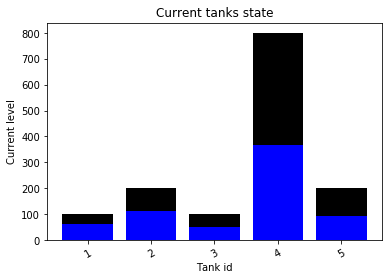

In [13]:
test_Q()
#print(np.mean(test_rewards_list) )

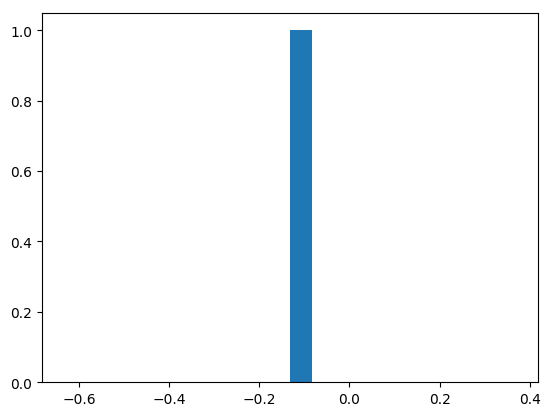

In [14]:
%matplotlib inline
mpl.rcParams.update(mpl.rcParamsDefault)
plt.hist(test_rewards_list, bins = 20)
plt.show()

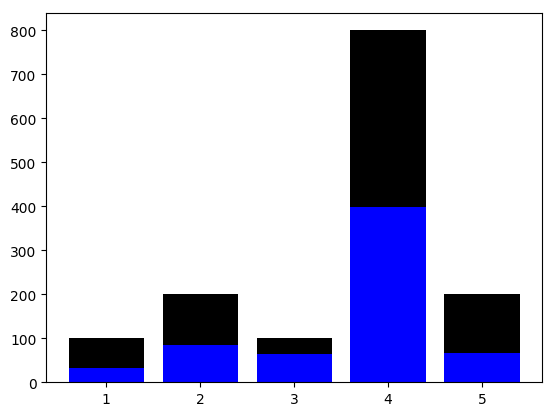

In [15]:
# Visualizing test simulation:

test_anim = ut.create_system_animation(test_visualization_steps, test_episodes * episode_length,test_freq)
HTML(test_anim.to_html5_video())


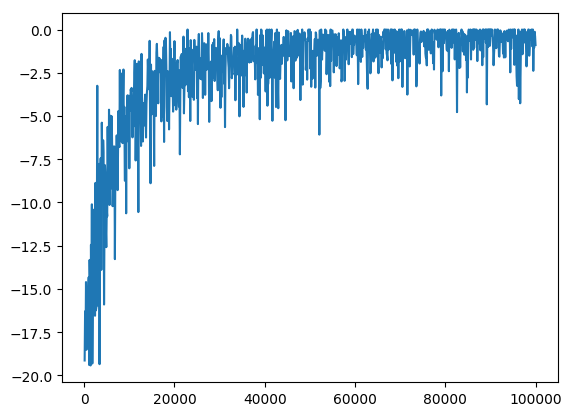

In [16]:
# Visualizing train simulation:

episode =episodes
#simulation_id = 2
step = 30
# discrewards_list = ut.load_obj(simulation_directory+"/discrewards/discrew-train-sim" + f"{simulation_id}" + "-" + f"{episode}")

# discrewards_list2 = [discrewards_list[i] for i in range(0,len(discrewards_list),step)]

# p = plt.plot([i for i in range(0,len(discrewards_list),step)], 
#              discrewards_list2)
# plt.savefig(simulation_directory+'/discrewards-sim' + f'{simulation_id}' + '.png')

discrewards = pd.read_table(rewards_file, sep = ",")

plt.plot(discrewards['episode'],discrewards['discreward'], label = "Discounted rewards")

plt.show()
plt.close()


In [17]:
len(list(Q))

24156

In [18]:
tank_levels = [test_visualization_steps[i][2] for i in range(len(test_visualization_steps))]
tank_levels_array = np.asarray(tank_levels).transpose()

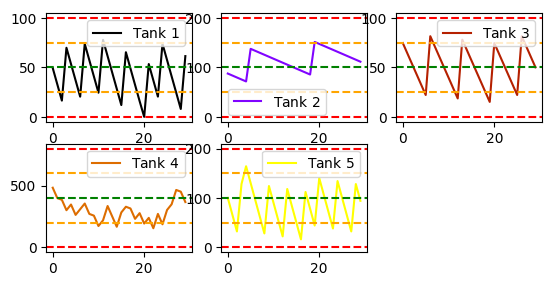

In [19]:
#DISCRETE LEVELS

cmap = plt.get_cmap('gnuplot')
colors = [cmap(i) for i in np.linspace(0, 1, n)]
lvl_colors = ["Orange", "Green","Orange"]

tanks = test_toy_system.tanks

for i, color in enumerate(colors, start=1):
    plt.subplot(3,3, i)    
    plt.plot(tank_levels_array[i-1], color=color, label='Tank ${i}$'.format(i=i))
    
    plt.axhline(y= tanks[i-1].max_load, xmin=0, xmax=episode_length, hold=None, color = "Red", linestyle = '--')
    for lvl_color, lvl in zip(lvl_colors, tanks[i-1].levels):
        plt.axhline(y= lvl, xmin=0, xmax=episode_length, hold=None, color = lvl_color, linestyle = '--')
    plt.axhline(y= 0, xmin=0, xmax=episode_length, hold=None, color = "Red", linestyle = '--')


    plt.legend(loc='best')
plt.show()

        

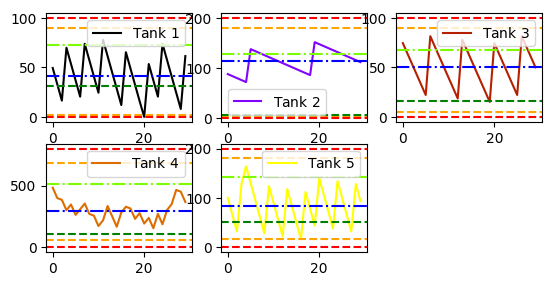

In [20]:
# THE REAL LEVELS (percentages 12h, 36h, ? h)

cmap = plt.get_cmap('gnuplot')
colors = [cmap(i) for i in np.linspace(0, 1, n)]
lvl_colors = ["Orange", "Green","Orange"]

tanks = test_toy_system.tanks

for i, color in enumerate(colors, start=1):
    plt.subplot(3,3, i)    

    plt.plot(tank_levels_array[i-1], color=color, label='Tank ${i}$'.format(i=i))
    
    plt.axhline(y= tanks[i-1].max_load, xmin=0, xmax=episode_length, hold=None, color = "Red", linestyle = '--')
    for lvl_color, lvl in zip(lvl_colors, tanks[i-1].level_percentages):
        plt.axhline(y= lvl * tanks[i-1].max_load, xmin=0, xmax=episode_length, hold=None, color = lvl_color, 
                    linestyle = '--')
    plt.axhline(y= 0, xmin=0, xmax=episode_length, hold=None, color = "Red", linestyle = '--')
    
    
    percentages = tanks[i-1].level_percentages           
    c = percentages[1]
    e = percentages[2]          
    d = ct.p0_GLOBAL*e+(1-ct.p0_GLOBAL)*c
    plt.axhline(y= d*tanks[i-1].max_load, xmin=0, xmax=episode_length, hold=None, color = "lawngreen", 
                linestyle = '-.')

    plt.axhline(y= np.mean(tank_levels_array[i-1]), xmin=0, xmax=episode_length, hold=None, 
                color = "blue", linestyle = '-.')
  


    plt.legend(loc='best')
#plt.show()
plt.savefig(simulation_directory + '/tank-levels-sim' + f'{simulation_id}' + '.pdf')

In [21]:
Episode: 100. Elapsed time  0.05  minuts. epsilon 0.9579 Discounted reward:  -28000041.108963497
Episode: 200. Elapsed time  0.11  minuts. epsilon 0.9187 Discounted reward:  -26000043.136069976
Episode: 300. Elapsed time  0.18  minuts. epsilon 0.8827 Discounted reward:  -20000040.21466474
Episode: 400. Elapsed time  0.27  minuts. epsilon 0.8494 Discounted reward:  -25000023.10632617
Episode: 500. Elapsed time  0.37  minuts. epsilon 0.8185 Discounted reward:  -24000028.114429202
Episode: 600. Elapsed time  0.5  minuts. epsilon 0.7898 Discounted reward:  -26000033.119467866
Episode: 700. Elapsed time  0.63  minuts. epsilon 0.763 Discounted reward:  -24000030.426938158
Episode: 800. Elapsed time  0.76  minuts. epsilon 0.7379 Discounted reward:  -22000037.105293885
Episode: 900. Elapsed time  0.88  minuts. epsilon 0.7145 Discounted reward:  -16000027.214738708
Episode: 1000. Elapsed time  1.01  minuts. epsilon 0.6925 Discounted reward:  -13000021.99472654
Episode: 1100. Elapsed time  1.16  minuts. epsilon 0.6718 Discounted reward:  -15000024.008988662
Episode: 1200. Elapsed time  1.31  minuts. epsilon 0.6524 Discounted reward:  -18000029.226717632
Episode: 1300. Elapsed time  1.47  minuts. epsilon 0.634 Discounted reward:  -19000028.52769577
Episode: 1400. Elapsed time  1.63  minuts. epsilon 0.6166 Discounted reward:  -22000036.44480863
Episode: 1500. Elapsed time  1.8  minuts. epsilon 0.6002 Discounted reward:  -12000018.0040637
Episode: 1600. Elapsed time  1.98  minuts. epsilon 0.5846 Discounted reward:  -16000031.228442688
Episode: 1700. Elapsed time  2.16  minuts. epsilon 0.5698 Discounted reward:  -23000051.112380963
Episode: 1800. Elapsed time  2.37  minuts. epsilon 0.5557 Discounted reward:  -13000020.038069973
Episode: 1900. Elapsed time  2.63  minuts. epsilon 0.5423 Discounted reward:  -21000021.34935867
Episode: 2000. Elapsed time  2.84  minuts. epsilon 0.5295 Discounted reward:  -12000014.993348014
Episode: 2100. Elapsed time  3.04  minuts. epsilon 0.5174 Discounted reward:  -13000017.050656565
Episode: 2200. Elapsed time  3.24  minuts. epsilon 0.5057 Discounted reward:  -18000029.338394843
Episode: 2300. Elapsed time  3.45  minuts. epsilon 0.4946 Discounted reward:  -9000007.996369414
Episode: 2400. Elapsed time  3.65  minuts. epsilon 0.484 Discounted reward:  -20000028.995834745
Episode: 2500. Elapsed time  3.87  minuts. epsilon 0.4738 Discounted reward:  -12000008.99960373
Episode: 2600. Elapsed time  4.09  minuts. epsilon 0.464 Discounted reward:  -8000001.990621154
Episode: 2700. Elapsed time  4.32  minuts. epsilon 0.4546 Discounted reward:  -15000022.313438928
Episode: 2800. Elapsed time  4.55  minuts. epsilon 0.4456 Discounted reward:  -11000011.050444487
Episode: 2900. Elapsed time  4.79  minuts. epsilon 0.437 Discounted reward:  -7000012.998633672
Episode: 3000. Elapsed time  5.02  minuts. epsilon 0.4287 Discounted reward:  -8000005.264682835
Episode: 3100. Elapsed time  5.27  minuts. epsilon 0.4206 Discounted reward:  -11000018.992927592
Episode: 3200. Elapsed time  5.5  minuts. epsilon 0.4129 Discounted reward:  -7000009.997351216
Episode: 3300. Elapsed time  5.77  minuts. epsilon 0.4055 Discounted reward:  -13000011.030119121
Episode: 3400. Elapsed time  6.0  minuts. epsilon 0.3983 Discounted reward:  -18000023.3058256
Episode: 3500. Elapsed time  6.24  minuts. epsilon 0.3914 Discounted reward:  -7000002.996427942
Episode: 3600. Elapsed time  6.49  minuts. epsilon 0.3847 Discounted reward:  -11000007.309740528
Episode: 3700. Elapsed time  6.75  minuts. epsilon 0.3782 Discounted reward:  -11000012.001738582
Episode: 3800. Elapsed time  7.01  minuts. epsilon 0.372 Discounted reward:  -8000003.996528433
Episode: 3900. Elapsed time  7.31  minuts. epsilon 0.3659 Discounted reward:  -9000012.050633566
Episode: 4000. Elapsed time  7.58  minuts. epsilon 0.3601 Discounted reward:  -6000005.9967362685
Episode: 4100. Elapsed time  7.85  minuts. epsilon 0.3544 Discounted reward:  -7000008.991066201
Episode: 4200. Elapsed time  8.11  minuts. epsilon 0.3489 Discounted reward:  -8000002.004340031
Episode: 4300. Elapsed time  8.39  minuts. epsilon 0.3436 Discounted reward:  -6000007.205459152
Episode: 4400. Elapsed time  8.66  minuts. epsilon 0.3384 Discounted reward:  -7000008.088827883
Episode: 4500. Elapsed time  8.92  minuts. epsilon 0.3334 Discounted reward:  -10000008.016246885
Episode: 4600. Elapsed time  9.21  minuts. epsilon 0.3285 Discounted reward:  -5000008.212606534
Episode: 4700. Elapsed time  9.51  minuts. epsilon 0.3238 Discounted reward:  -8000007.021665757
Episode: 4800. Elapsed time  9.79  minuts. epsilon 0.3192 Discounted reward:  -8000008.038475299
Episode: 4900. Elapsed time  10.07  minuts. epsilon 0.3147 Discounted reward:  -18000020.03056307
Episode: 5000. Elapsed time  10.39  minuts. epsilon 0.3104 Discounted reward:  -10000006.999470046
Episode: 5100. Elapsed time  10.76  minuts. epsilon 0.3062 Discounted reward:  -7000004.998659743
Episode: 5200. Elapsed time  11.05  minuts. epsilon 0.3021 Discounted reward:  -7000007.06712629
Episode: 5300. Elapsed time  11.38  minuts. epsilon 0.2981 Discounted reward:  -8000009.999546508
Episode: 5400. Elapsed time  11.69  minuts. epsilon 0.2942 Discounted reward:  -5000000.995678231
Episode: 5500. Elapsed time  11.99  minuts. epsilon 0.2904 Discounted reward:  -4000003.9933600356
Episode: 5600. Elapsed time  12.29  minuts. epsilon 0.2867 Discounted reward:  -11000004.996177264
Episode: 5700. Elapsed time  12.59  minuts. epsilon 0.2831 Discounted reward:  -6000003.999741462
Episode: 5800. Elapsed time  12.9  minuts. epsilon 0.2795 Discounted reward:  -2000006.9925141241
Episode: 5900. Elapsed time  13.2  minuts. epsilon 0.2761 Discounted reward:  -8000007.987305785
Episode: 6000. Elapsed time  13.54  minuts. epsilon 0.2728 Discounted reward:  -4000000.993550161

SyntaxError: invalid syntax (<ipython-input-21-cba0d1b1badc>, line 1)